# Description of the project

The Clear Taxi company has collected historical data on taxi orders at airports.
<br>In order to attract more drivers during the peak period, you need to predict the number of taxi orders for the next hour.
<br>It is necessary to build a model for such a prediction.
<br>The value of the RMSE metric on the test sample should not exceed 48.

# Description of data

The data is in the file `/datasets/taxi.csv`
<br>The number of orders is in the `num_orders` column

# Action plan

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters (make a test sample of 10% of the original data).
4. Check the data on the test sample and draw conclusions.

# Loading and resampling data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

pd.set_option('display.max_row',100)
pd.set_option('display.max_columns',100)

In [31]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0],sep=',')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Ресемплируем данные по одному часу

In [4]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# Data analysis

Check the indices for monotonicity

In [5]:
df.index.is_monotonic

True

Total number of rows and number of missing values

In [6]:
a = df['num_orders'].count()
b = df['num_orders'].isna().sum()
print(a)
print(b)
100*b/a

4416
0


0.0

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

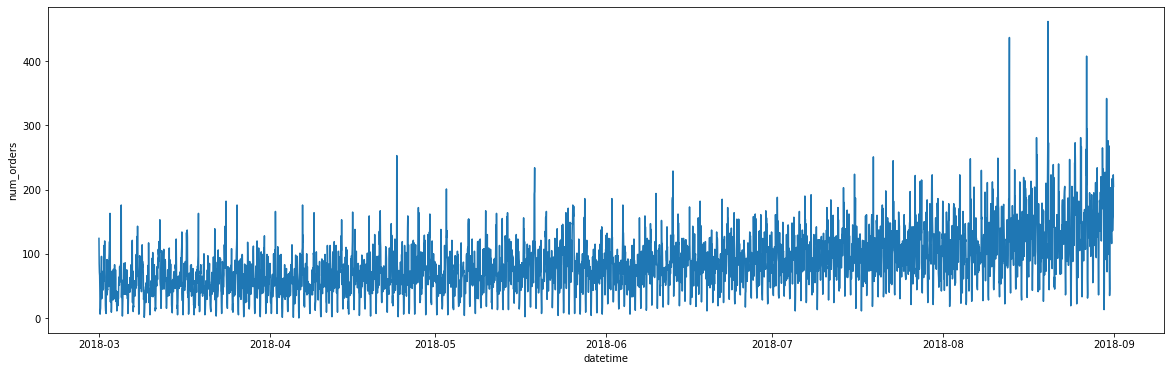

In [7]:
plt.figure(figsize=(20, 6))
sns.lineplot(x=df.index,y=df['num_orders'])

Взглянем в разрезе 21-го дня

In [8]:
df_1_7 = df['2018-03-01':'2018-03-07']
df_8_14 = df['2018-03-08':'2018-03-14']
df_15_21 = df['2018-03-15':'2018-03-21']

Text(0.5, 0, '')

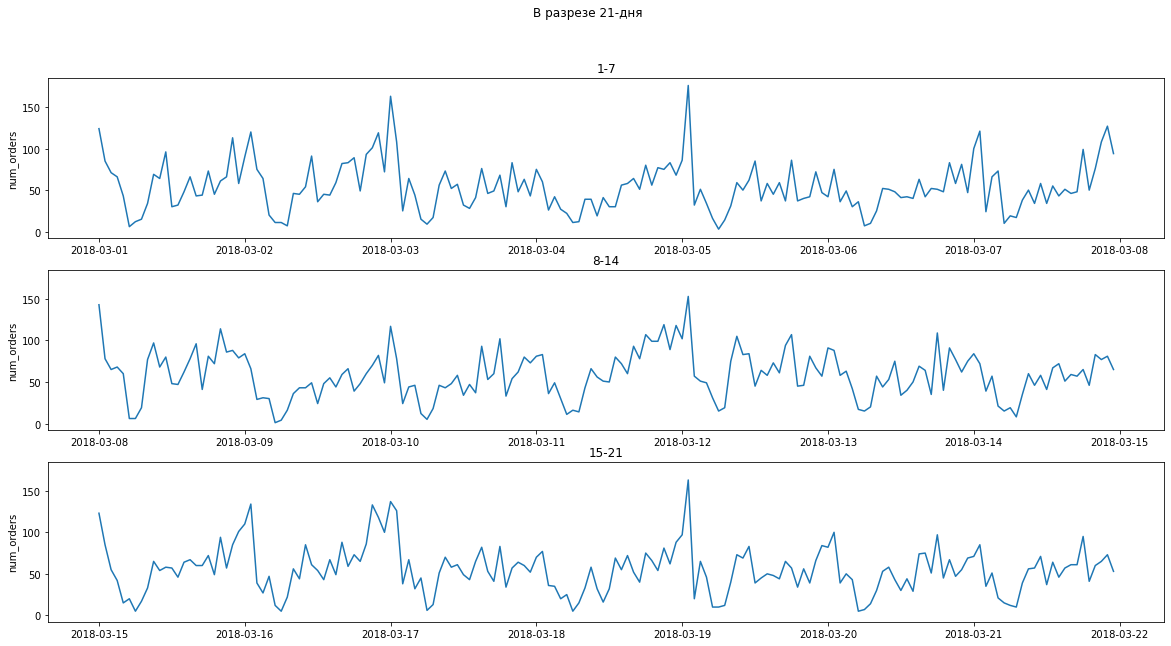

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10), sharey=True)
fig.suptitle('In the context of 21 days')

sns.lineplot(ax=axes[0], x=df_1_7.index,y=df_1_7['num_orders'])
axes[0].set_title('1-7')
axes[0].set_xlabel('')

sns.lineplot(ax=axes[1], x=df_8_14.index,y=df_8_14['num_orders'])
axes[1].set_title('8-14')
axes[1].set_xlabel('')

sns.lineplot(ax=axes[2], x=df_15_21.index,y=df_15_21['num_orders'])
axes[2].set_title('15-21')
axes[2].set_xlabel('')

Let's build the same graphs, but in the next months

In [10]:
df_1_7 = df['2018-04-01':'2018-04-07']
df_8_14 = df['2018-04-08':'2018-04-14']
df_15_21 = df['2018-04-15':'2018-04-21']

Text(0.5, 0, '')

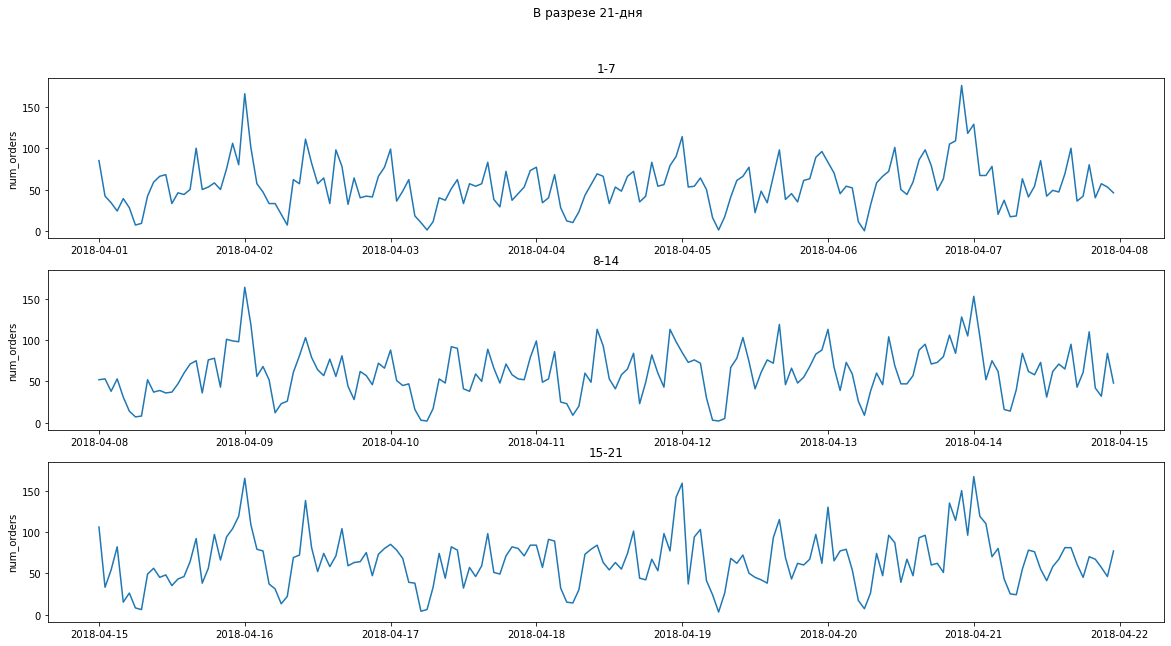

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10), sharey=True)
fig.suptitle('In the context of 21 days')

sns.lineplot(ax=axes[0], x=df_1_7.index,y=df_1_7['num_orders'])
axes[0].set_title('1-7')
axes[0].set_xlabel('')

sns.lineplot(ax=axes[1], x=df_8_14.index,y=df_8_14['num_orders'])
axes[1].set_title('8-14')
axes[1].set_xlabel('')

sns.lineplot(ax=axes[2], x=df_15_21.index,y=df_15_21['num_orders'])
axes[2].set_title('15-21')
axes[2].set_xlabel('')

As you can see, the workload schedules during the week are similar.
<br>We continue to consider in more detail

Let's build a graph of trends and seasonality

In [12]:
decomposed = seasonal_decompose(df)

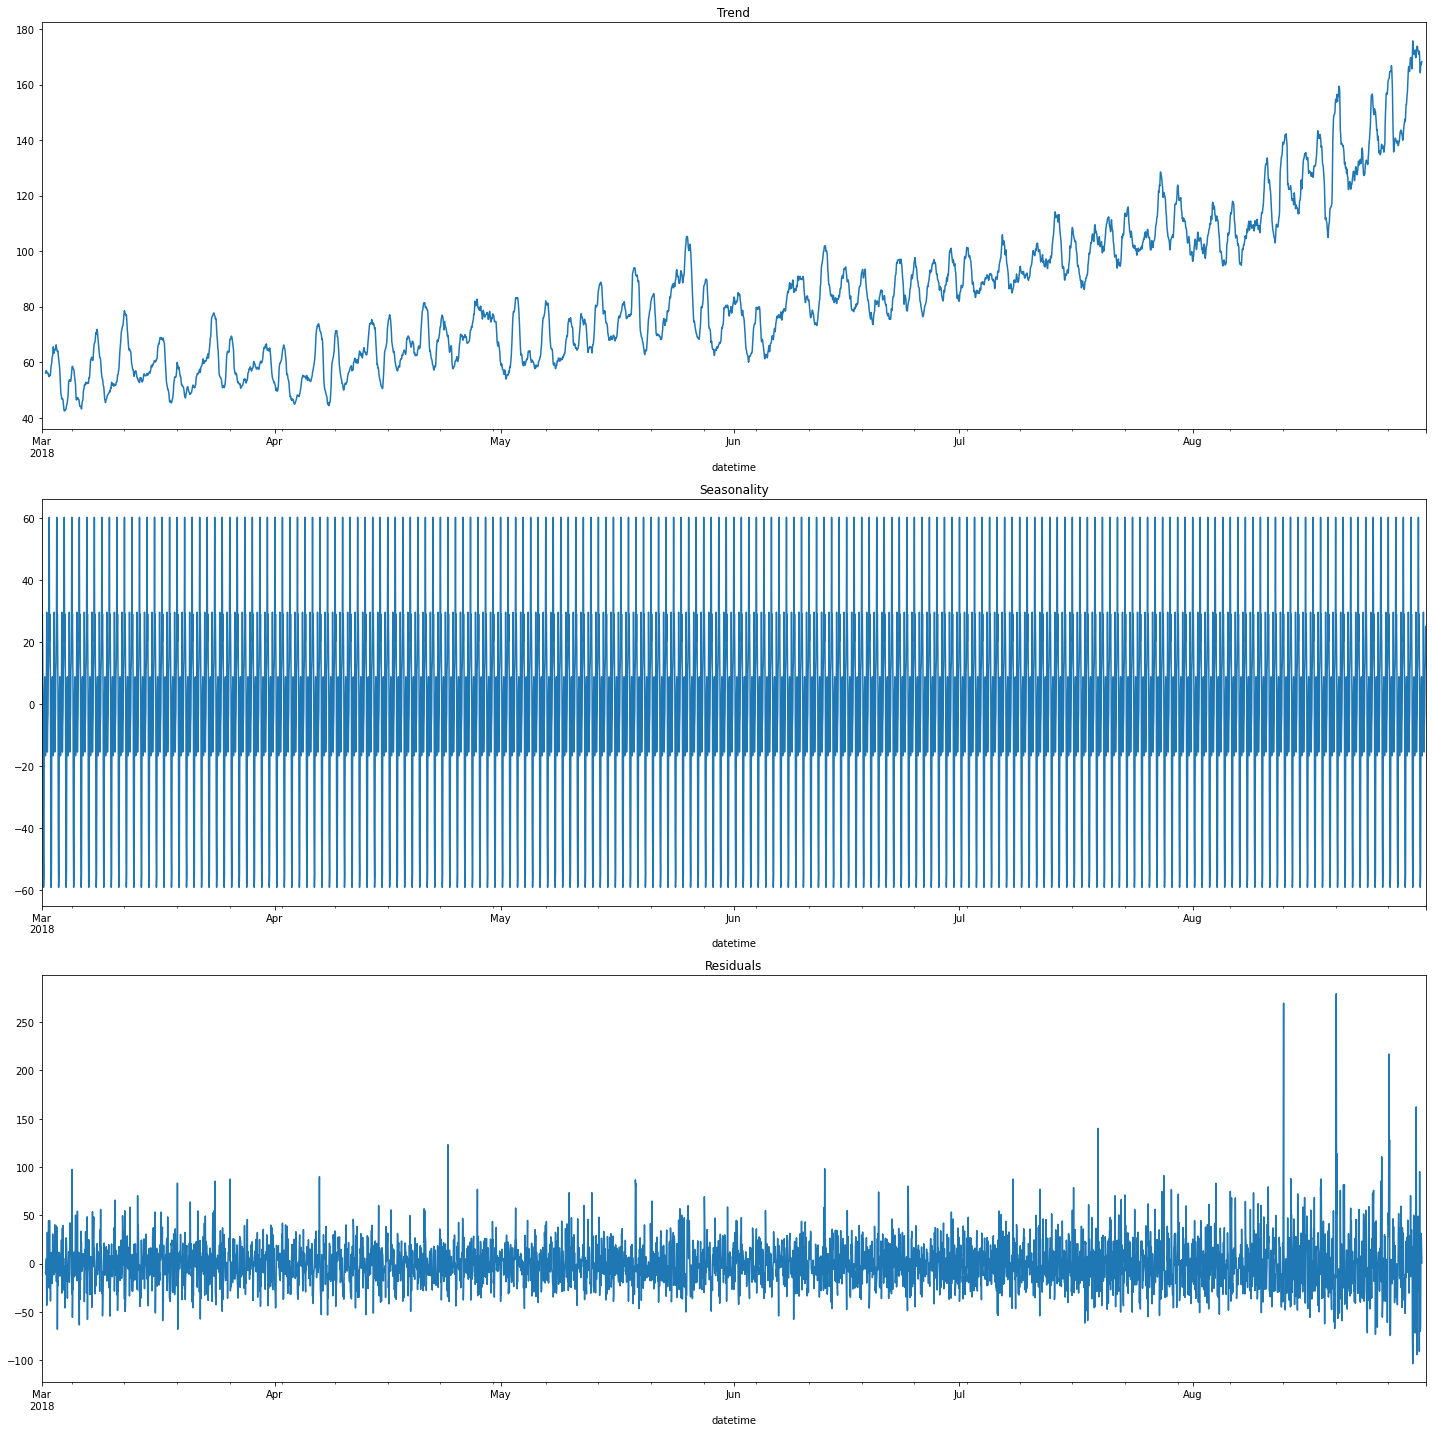

In [13]:
plt.figure(figsize=(20, 20))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')

plt.tight_layout()

There is a trend to increase the number of orders per day, orders do not depend on seasonality

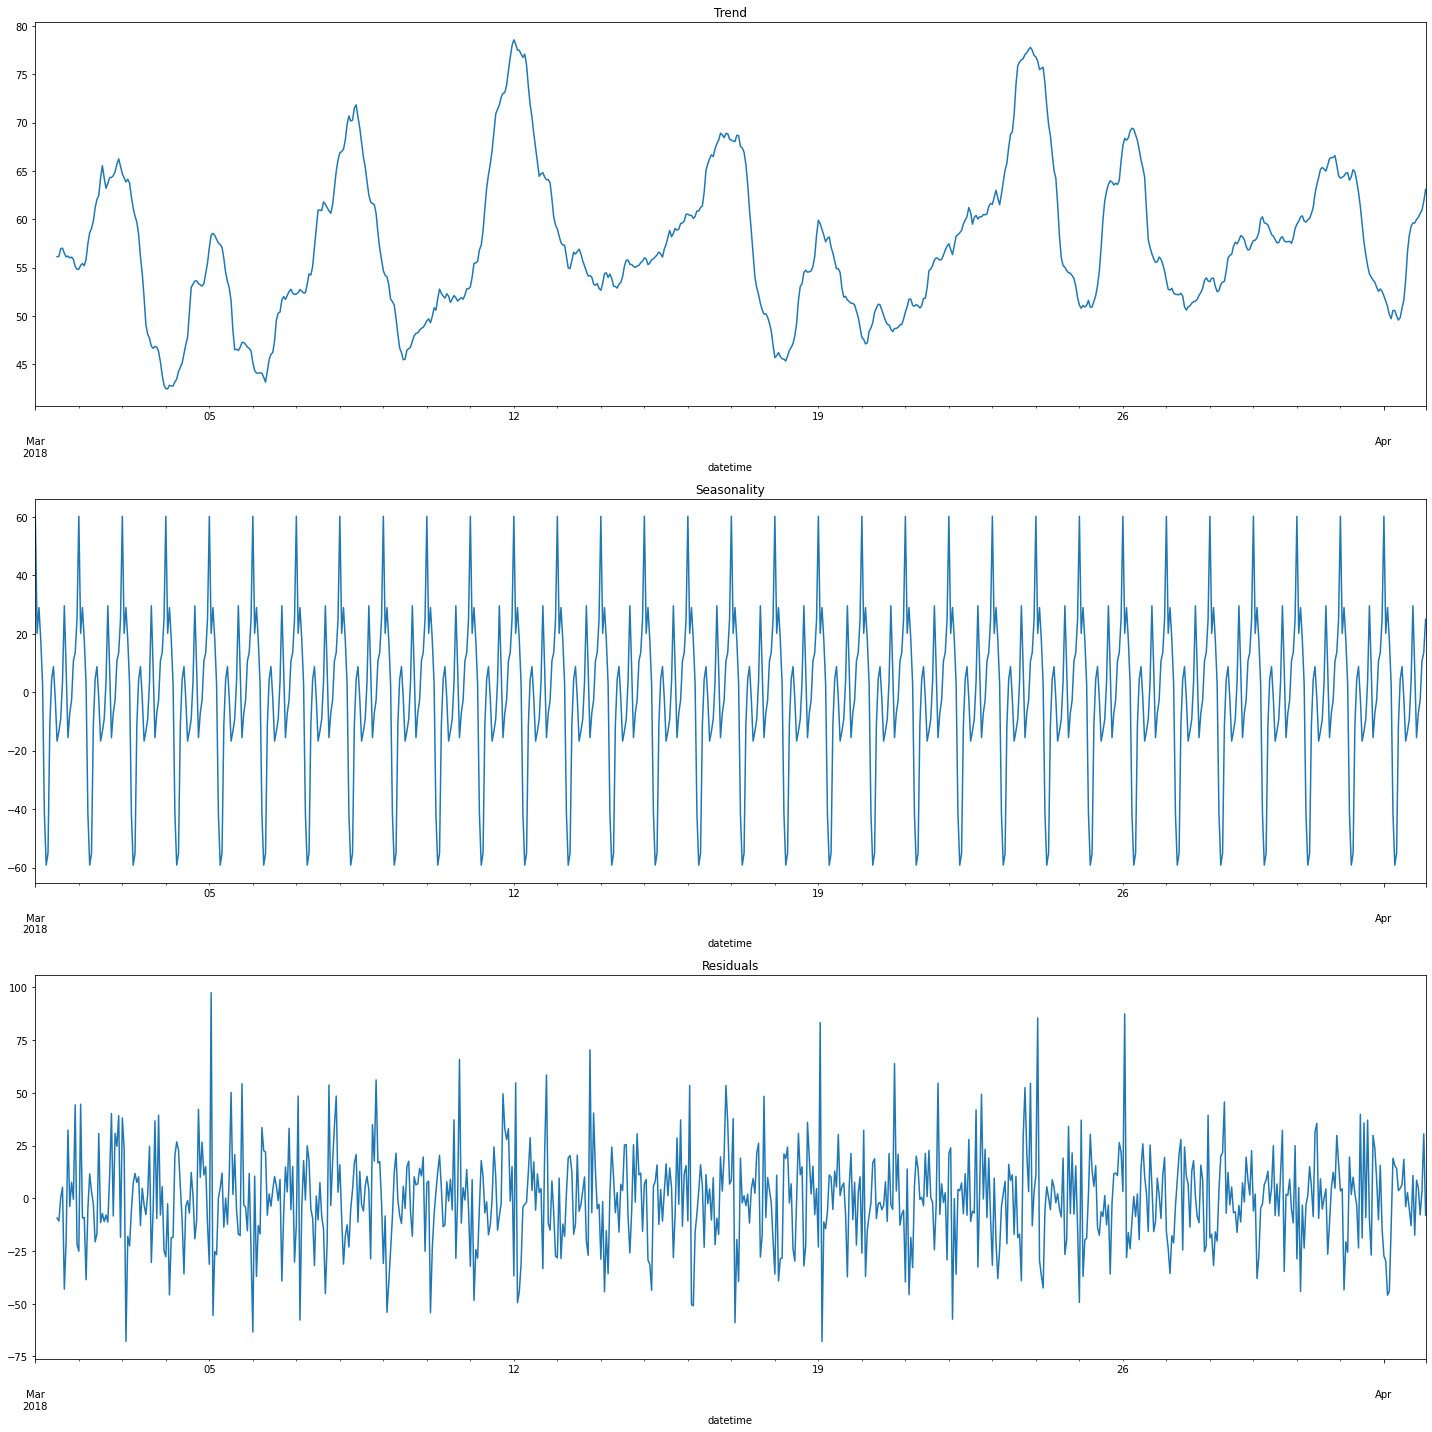

In [14]:
plt.figure(figsize=(20, 20))
plt.subplot(311)

decomposed.trend['2018-03-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-04-01'].plot(ax=plt.gca()) 
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid['2018-03-01':'2018-04-01'].plot(ax=plt.gca()) 
plt.title('Residuals')

plt.tight_layout()

## Conclusion

The data has been analyzed.
<br>Load schedules are similar during the week.
<br>There is a trend to increase the number of orders per day over time, the number of orders does not depend on the season

# Building forecast models for orders for the next hour

## Preparing data for models

Define a function that adds new features

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Let's add new features

In [16]:
data = copy.deepcopy(df)
make_features(data, 20, 2)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   month         4416 non-null   int64  
 2   day           4416 non-null   int64  
 3   dayofweek     4416 non-null   int64  
 4   lag_1         4415 non-null   float64
 5   lag_2         4414 non-null   float64
 6   lag_3         4413 non-null   float64
 7   lag_4         4412 non-null   float64
 8   lag_5         4411 non-null   float64
 9   lag_6         4410 non-null   float64
 10  lag_7         4409 non-null   float64
 11  lag_8         4408 non-null   float64
 12  lag_9         4407 non-null   float64
 13  lag_10        4406 non-null   float64
 14  lag_11        4405 non-null   float64
 15  lag_12        4404 non-null   float64
 16  lag_13        4403 non-null   float64
 17  lag_14        4402 non-null

Remove NaN values

In [17]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4396 entries, 2018-03-01 20:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4396 non-null   int64  
 1   month         4396 non-null   int64  
 2   day           4396 non-null   int64  
 3   dayofweek     4396 non-null   int64  
 4   lag_1         4396 non-null   float64
 5   lag_2         4396 non-null   float64
 6   lag_3         4396 non-null   float64
 7   lag_4         4396 non-null   float64
 8   lag_5         4396 non-null   float64
 9   lag_6         4396 non-null   float64
 10  lag_7         4396 non-null   float64
 11  lag_8         4396 non-null   float64
 12  lag_9         4396 non-null   float64
 13  lag_10        4396 non-null   float64
 14  lag_11        4396 non-null   float64
 15  lag_12        4396 non-null   float64
 16  lag_13        4396 non-null   float64
 17  lag_14        4396 non-null

Divide the sample into sets with features and a target feature

In [18]:
features = data.drop(['num_orders'],axis=1)
target = data['num_orders']

Let's break the sets into train and test in the ratio of `9:1`

In [19]:
# features_train, features_test = train_test_split(features, test_size=0.1, shuffle=False)
# target_train, target_test = train_test_split(target, test_size=0.1, shuffle=False)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False)

print(features.shape)
print(target.shape)
print()

print(features_train.shape)
print(target_train.shape)
print()

print(features_test.shape)
print(target_test.shape)

(4396, 24)
(4396,)

(3956, 24)
(3956,)

(440, 24)
(440,)


## Linear regression

In [20]:
%%time
model_l_r = LinearRegression()
model_l_r.fit(features_train, target_train)
predictions_train = model_l_r.predict(features_train)
rmse_train = mean_squared_error(predictions_train, target_train) ** 0.5
print('RMSE of a linear model on a train set:', rmse_train)

predictions_test = model_l_r.predict(features_test)
rmse_test = mean_squared_error(predictions_test, target_test) ** 0.5
print('RMSE of a linear model on a test set:', rmse_test)

RMSE линейной модели на тренировочной выборке: 29.27178625966362
RMSE линейной модели на тестовой выборке: 55.10650162930425
Wall time: 19 ms


## Decision tree

In [21]:
%%time
param_grid = {'max_depth': range(1,100)}
tscv = TimeSeriesSplit(n_splits=5)

dtr = GridSearchCV(estimator=DecisionTreeRegressor(random_state=12345), param_grid=param_grid, cv=tscv)
dtr.fit(features_train, target_train)
dtr.best_params_

Wall time: 18.3 s


{'max_depth': 7}

In [22]:
predictions_train = dtr.predict(features_train)
rmse_train = mean_squared_error(predictions_train, target_train) ** 0.5
print('RMSE of the decision tree on the train set:', rmse_train)

predictions_test = dtr.predict(features_test)
rmse_test = mean_squared_error(predictions_test, target_test) ** 0.5
print('RMSE of the decision tree on the test set:', rmse_test)

RMSE решающего деерва на тренировочной выборке: 24.179008328068996
RMSE решающего деерва на тестовой выборке: 73.2469838951034


## Random forest

In [23]:
%%time
param_grid = {'n_estimators': range(1,50,2), 'max_depth': range(1,20,2)}
tscv = TimeSeriesSplit(n_splits=5)

rfr = GridSearchCV(estimator=RandomForestRegressor(random_state=12345), param_grid=param_grid, cv=tscv)
rfr.fit(features_train, target_train)
rfr.best_params_

Wall time: 6min 34s


{'max_depth': 17, 'n_estimators': 49}

In [24]:
predictions_train = rfr.predict(features_train)
rmse_train = mean_squared_error(predictions_train, target_train) ** 0.5
print('RMSE of the random forest on the train set:', rmse_train)

predictions_test = rfr.predict(features_test)
rmse_test = mean_squared_error(predictions_test, target_test) ** 0.5
print('RMSE of a random forest on a test set:', rmse_test)

RMSE случайного леса на тренировочной выборке: 10.189319011575929
RMSE случайного леса на тестовой выборке: 50.90489002028426


## LightGBM

In [25]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.005,
    'verbose': 0,
    "max_depth": 20,
    "num_iterations": 100000,
    "n_estimators": 1000
}

In [26]:
%%time
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(features_train, target_train, verbose=0)
gbm.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Wall time: 2min 9s


defaultdict(collections.OrderedDict, {})

In [27]:
predictions_train = gbm.predict(features_train)
rmse_train = mean_squared_error(predictions_train, target_train) ** 0.5
print('RMSE LightGBM on the train set:', rmse_train)

predictions_test = gbm.predict(features_test)
rmse_test = mean_squared_error(predictions_test, target_test) ** 0.5
print('RMSE LightGBM on test set:', rmse_test)

RMSE LightGBM на тренировочной выборке: 2.120561365286103e-05
RMSE LightGBM на тестовой выборке: 46.118613743387364


Let's look at the importance of LightGBM factors

In [28]:
feature_importances = pd.DataFrame(gbm.feature_importances_,
                                   index = features.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
lag_6,228897
lag_17,194412
lag_8,169732
lag_19,149002
lag_20,144376
lag_18,134949
lag_3,133590
lag_10,129237
lag_14,128992
lag_11,122583


# Conclusion

As can be seen from the results on the test dataset, LightGBM takes first place, and random forest is in second place.
<br>It should also be taken into account that LightGBM works, in this case, 3 times faster than random forest.
<br>It is worth noting that in order to get `rmse` less than 48, several iterations were carried out with the regulation of not only the hyperparameters of the models, but also, what is especially important, with the regulation of the number of differences in the time series and the size of the averaging window